<h1> Business Case & Data Modelling (Short Track) </h1>

<h3> I - Relatório </h3>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_excel('data/sample.xls')

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df.info()

In [ ]:
# checar inf, valores nulos e parte descritiva.
missing = df.isnull().sum()
missing

df.describe()

##### a coluna 'Postal Code' deve ser ignorada por estar com o tipo int

#### Pontos a se considerar até agora:
- <b>Sales</b>: A faixa de valores é extensa, o que pode parecer estranho logo de cara, mas há vendas corporativas.
- <b>Discount</b>: Varia de 0% a 80%, pode ser examinado mais a fundo em como isso impacta o lucro da empresa.
- <b>Profit</b>: Vai de aproximadamente - 6.600 a 8.400 (há perdas muito grandes em vendas). Há um grande desvio padrão, sugerindo grande variação na rentabilidade.

In [ ]:
sns.set_style("whitegrid")

# Plotting distributions and outliers for Sales and Profit
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Distribution of Sales
sns.boxplot(ax=axes[0], x=df['Sales'])
axes[0].set_title('Distribuição de Vendas (Sales)')

# Distribution of Profit
sns.boxplot(ax=axes[1], x=df['Profit'])
axes[1].set_title('Distribuição de Lucros (Profit)')

plt.show()

A coluna de Sales apresenta um grande número de outliers, onde estes podem representar compras em grandes quantidades (compra corporativa) ou items com valores muito altos (ex: geladeiras, tv's)
<br>Em se tratanto da coluna de Lucro (Profit), há um grande número de outliers, mas em ambos os lados. Podem fazer jus as perdas, como o valor supracitado de 6.600, bem como uma venda alta de 8.400.
<br>Embora o dataset não tenha missing ou algo do tipo, existem transações que são significativamente diferentes da maioria, nessas duas colunas. Uma análise mais aprofundada poderia envolver o exame das características destas transacções atípicas para entender o que contribui para vendas ou lucros elevados, bem como as transações que resultam em perdas. Isto poderia fornecer informações sobre as operações comerciais, tais como quais produtos ou estratégias de vendas são mais eficazes, ou identificar áreas onde os custos precisam ser controlados.

In [ ]:
# identificar os outliers presentes em ambas as colunas

In [ ]:
# Define a function to identify outliers based on the 1.5*IQR rule
def busca_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

sales_outliers = busca_outliers(df, 'Sales')
profit_outliers = busca_outliers(df, 'Profit')

# Summary of outliers
outlier_summary = {
    'Sales Outliers Count': sales_outliers.shape[0],
    'Profit Outliers Count': profit_outliers.shape[0],
    'Total Transactions': df.shape[0]
}

outlier_summary

Para a coluna de vendas, pode ser que os oultliers representem <b>11%</b> dos dados. Enquanto que para a coluna lucro aproximadamente <b>19%</b>.
<br> Continuando com a análise de ouliters, vale a pena continuar explorando qual o motivo de acontecer, vendo se há categorias e produtos onde ocorrem mais, se há mais casos em consumidores ou corporativo e até mesmo localização, para achar padrões de consumo.

In [ ]:
sales_outliers.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].sum().sort_values(by='Sales', ascending=False)

In [ ]:
profit_outliers.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].sum().sort_values(by='Profit', ascending=False)

In [ ]:
outliers_joint = pd.concat([sales_outliers, profit_outliers]).drop_duplicates()

In [ ]:
outliers_by_product = outliers_joint.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].agg(['sum', 'mean', 'count'])
outliers_by_product_sales = outliers_by_product.sort_values(by=('Sales', 'sum'), ascending=True)
outliers_by_product_profit = outliers_by_product.sort_values(by=('Profit', 'sum'), ascending=True)

In [ ]:
# criar dataframe sem os considerados outliers
row_id = []
row_id.append(sales_outliers['Row ID'].tolist())
row_id = row_id + profit_outliers['Row ID'].tolist()
no_outliers = df[~df['Row ID'].isin(row_id)]

In [ ]:
# comparar sales e profit

In [ ]:
sales_outliers.groupby(

In [ ]:
total_sales_outlier = sales_outliers['Sales'].sum()
total_profit_outlier = profit_outliers['Profit'].sum()

total_sales_no = no_outliers['Sales'].sum()
total_profit_no = no_outliers['Profit'].sum()

total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()

In [ ]:
no_outliers.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].sum().sort_values(by='Sales', ascending=False)

In [ ]:
sales_outliers.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].sum().sort_values(by='Sales', ascending=False).reset_index()

In [ ]:
data = df.copy()

In [ ]:
data['Outlier'] = 'Non-Outlier'
data.loc[outliers_joint.index, 'Outlier'] = 'Outlier'

In [ ]:
data['Outlier'].value_counts()

In [ ]:
data

In [ ]:
# Initialize a matplotlib figure with a size
plt.figure(figsize=(12, 6))

# Plot for Sales
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
sns.boxplot(x='Outlier', y='Sales', data=data)
plt.title('Sales: Outliers vs Non-Outliers')

# Plot for Profit
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
sns.boxplot(x='Outlier', y='Profit', data=data)
plt.title('Profit: Outliers vs Non-Outliers')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
totals = data.groupby('Outlier')[['Sales', 'Profit']].sum().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Total Sales Comparison
ax[0].bar(totals['Outlier'], totals['Sales'], color=['lightgreen', '#FF7F7F'])
ax[0].set_title('Sales')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Total Sales')
ax[0].set_xticklabels(totals['Outlier'], rotation=45)

# Total Profit Comparison
ax[1].bar(totals['Outlier'], totals['Profit'], color=['lightgreen', '#FF7F7F'])
ax[1].set_title('Profit')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Total Profit')
ax[1].set_xticklabels(totals['Outlier'], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
nout_sales = totals['Sales'][0]
nout_profit = totals['Profit'][0]

out_sales = totals['Sales'][1]
out_profit = totals['Profit'][1]

In [ ]:
diff_sales = round(out_sales / (out_sales+ nout_sales) * 100,1)
diff_profit = round(out_profit / (out_profit+ nout_profit) * 100,1)

In [ ]:
print(diff_sales, diff_profit)

Como visto acima, as vendas para aquelas considerados outliers, representam <b>75.8%</b> do total de vendas. Não obstante, para o lucro, representa <b>69.3%</b>. Os outliers de fato são outliers?
<br> Parece que há uma necessidade de ir muito além dessa análise rasa, utilizando outras técnicas além do IQR, como Z-score, DBScan (identificaria os outliers como ruídos, Isolation Forest - técnica de ML para identificação robusta de outliers. Penso que também haveria uma definição de business sobre o que de fato são outliers, se realmente são ruídos e os dados não fazem sentido; isto é, estariam atrapalhando para uma análise mais profunda e possível uso de ML, ou simplesmente são casos fora da curva, como perdas nas vendas e valores altos, tanto em quantidade como em lucro.

Além disso, possíveis próximas etapas que estariam envolvidas nessa EDA seriam:
- <b>análise de tendências</b> - para verificar ao longo do tempo como se deu esse comportamento, podendo mostrar padrões sasonais e até mesmo mudanças em comportamentos no negócio que podem ter impactado vendas/receitas.
- <b>análise de segmentação</b> - assim como separado por categorias, subcategorias e consumidores e corporate, ainda sim poderia haver analises voltadas para regiões, sabendo em quais produtos, regiões e épocas do ano os esforços devem ser concentrados.
- <b>performance do produto</b> - identificar os mais vendidos e mais lucrativos, removendo aqueles que podem dar altos prejuízos e aumentando o lucro bruto/liquido final.
- <b>descontos</b> - como os descontos impactam as vendas e lucros? Como há descontos de até 80%, isso pode de fato estar comprometendo a receita da empresa. Se analisado de maneira mais profunda, regras do negócio poderiam mudar, entendo o comportamento do consumidor ao longo do tempo e onde de fato os descontos seriam válidos.

<h3> II - Engenharia </h3>

In [6]:
# carregando os dados no formato json
json_data = pd.read_json('data/data.json')
cols = json_data.columns.tolist()
with open('data/data.json') as f: data = json.load(f)

In [7]:
# normalizando o dicionario da coluna ItemList para novas colunas no mesmo dataframe
df = (pd.json_normalize(data, 'ItemList', cols)
             .drop(columns=['ItemList']))

In [12]:
# criando a tabela de produtos
produtos = df[['ProductName', 'Value']].drop_duplicates().reset_index(drop=True)
produtos['ProductID'] = produtos.index + 1

# criando a tabela de notas fiscais e removendo notas duplicadas (caso houvesse)
nfe = df[['NFeID', 'NFeNumber', 'CreateDate', 'EmissionDate']].drop_duplicates().reset_index(drop=True)

# criando a tabela de itens das notas, mapeando os produtos em seus respectivos ids.

product_to_id = produtos.set_index('ProductName')['ProductID'].to_dict()
itens_nfe = df[['NFeID', 'ProductName', 'Quantity', 'Discount']].copy()
itens_nfe['ItensID'] = itens_nfe.index + 1
itens_nfe['ProductID'] = itens_nfe['ProductName'].map(product_to_id)
itens_nfe.drop('ProductName', axis=1, inplace=True)


In [13]:
produtos

,ProductName,Value,ProductID
0,Rice,35.55,1
1,Flour,11.55,2
2,Bean,27.15,3
3,Tomate,12.25,4
4,Pasta,7.55,5
5,Beer,9.00,6
6,French fries,10.99,7
7,Ice cream,27.15,8


In [14]:
nfe

,NFeID,NFeNumber,CreateDate,EmissionDate
0,1,501,2021-05-24T20:21:34.79,2021-05-24T00:00:00
1,2,502,2021-05-24T20:21:34.79,2021-05-24T00:00:00
2,3,503,2021-05-24T20:21:34.79,2021-05-24T00:00:00


In [15]:
itens_nfe

,NFeID,Quantity,Discount,ItensID,ProductID
0,1,2,0.0,1,1
1,1,5,0.0,2,2
2,1,7,0.0,3,3
3,2,10,0.0,4,4
4,2,5,0.0,5,5
5,3,6,0.0,6,6
6,3,2,0.0,7,7
7,3,1,0.0,8,8


In [ ]:
# Ao final, temos 3 tabelas que mostram a relações entre os dados, seja o produto em si, a nota fiscal da compra e os itens contidos em cada nfe.

<h3> III - Arquitetura </h3>

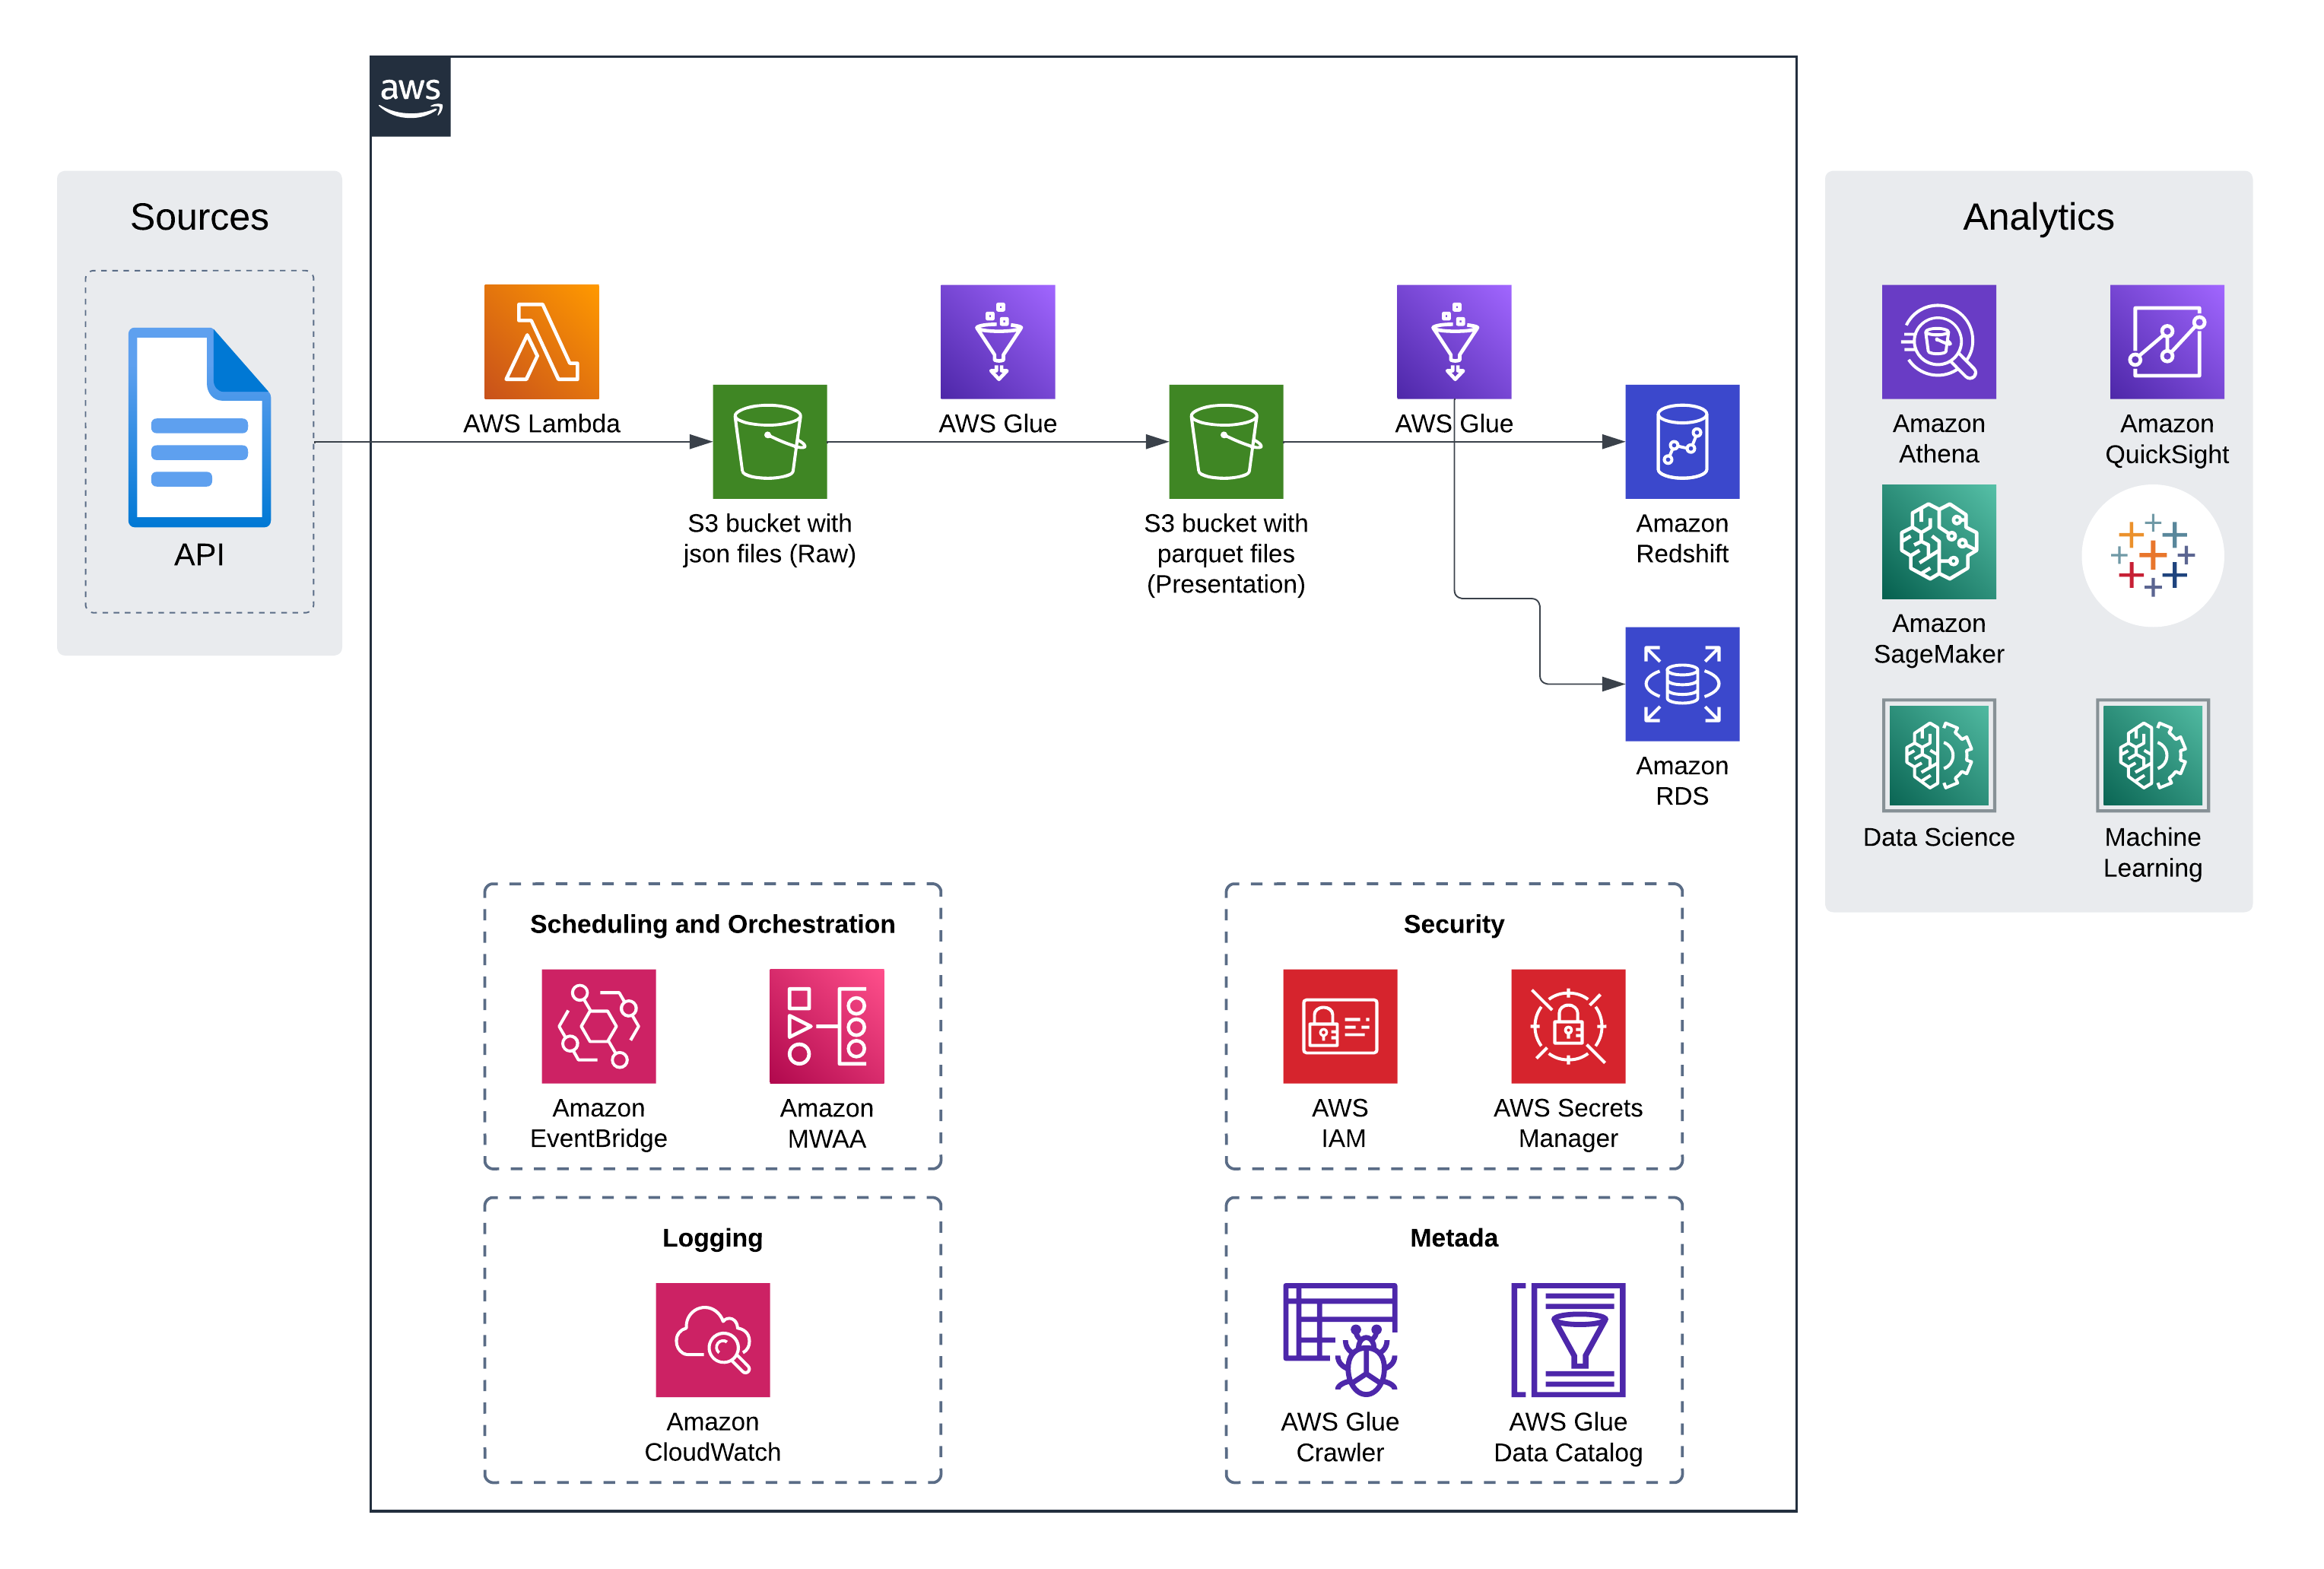

In [16]:
from IPython.display import Image
Image("img/arch.png")

Detalhando mais a arquitetura, O EventBridge seria responsável por disperar a função lambda que faria o download do arquivo por um get e jogando o mesmo para um bucket definido como Raw, onde conteria os arquivos .json.
<br> Após isso, o Glue seria acionado, onde após o processo de coleta de metadados pelo crawler -> data catalogo, realizaria a transformação do dicionário incluido na coluna "item_list" para novas colunas no mesmo dataframe, criando após isso, um arquivo .parquet, que possivelmente irá economizar recursos no s3 e apresenta um desempenho melhor em próximos usos.
<br> Outro glue job faria a inserção desses dados em algum RDS, como o Aurora, para persisti-los e caso haja a necessidade de usa-los; enquanto que os mesmos dados iriam para o Redshift a fim de se utiliza-lo como data warehouse, permitindo um ambiente rápido para analytics e outras transformações que possam surgir.
<br> Por fim, há diversas ferramentas a serem utilizadas para fazer EDA, modelos de ML e criação de dashboards, como supracitadas na imagem.

<br>Para fins de funcionamento da arquitetura, contariamos com o uso do IAM para provisionar o gerenciamento de acessos e o Secrets Managers para armazenar seguramente possíveis dados de acesso a determinada API. o CloudWatch ficaria responsável em armazenar o log de nossa infra, para entendermos possíveis erros no processamento e até mesmo demoras. Não obstante a tudo isso, o MWAA permitiria o uso do Airflow para orquestrar todo esse pipeline de dados.

<br>Como uma melhora futura o CloudWatch poderia ser integrado a outra ferramenta como o SNS para prover erros possíveis e definidos, onde poderia-se executar scripts auxiliares para realizar esse processo de ETL. Além disso, o uso do step functions também seria possível, já que é uma arquitetura simples e permitiram uma melhor visualização das etapas também. Para cargas maiores e, para estar preparado para processamento mais intensos, poderia haver gatilhos definidos para privisionar um cluster EMR para processamento dos dados ao invés do glue cuidar disso, uma vez que conseguiriamos definir detalhes referentes a configurações do Spark e Yarn.

<br>Como dito na EDA, há diversos possíveis usos dos dados, como análise do comportamento e até verificação de tendências que poderiam ser feitas por meio de séries temporais, que poderiam contar com o desenvolvimento de notebooks e posteriormente uso do sagemaker ou até mesmo EKS, para utilizarmos o MlFlow dentro do próprio Kubernets e realizar e monitor experimentos acerca dos diversos insights obtidos.